In [2]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# y -> outlet liquid temperature
# q(t) -> liquid flow rate
# Narx -> yhat(t+1|t) = f(y(t) ... y(t-3) u(t) ... u(t-9))

#read data
data = open('../exchanger/exchanger.dat')
lst = []
for line in data:
    lst += [line.split()]
time = [float(x[0]) for x in lst]
u = [float(x[1]) for x in lst]
y = [float(x[2]) for x in lst]

In [87]:
#divide identification set and validation set
ID_LENGHT = 3000
VAL_LENGHT = 1000
time_id = time[:ID_LENGHT]
u_id = u[:ID_LENGHT]
y_id = y[:ID_LENGHT]
avg_y_id = np.mean(y_id)
avg_u_id = np.mean(u_id)

time_val = time[ID_LENGHT:]
u_val = u[ID_LENGHT:]
y_val = y[ID_LENGHT:]
avg_y_val = np.mean(y_val)
avg_u_val = np.mean(u_val)

AR_deg = 5
X_deg = 5
poly_degree = 5

In [88]:
features = []
for i in reversed(range(X_deg)):
    if i==0:
        features.append("u(t)")
    else:
        features.append("u(t-{})".format(i))
for i in reversed(range(AR_deg)):
    if i==0:
        features.append("y(t)")
    else:
        features.append("y(t-{})".format(i))
print(features)
        

poly = PolynomialFeatures(poly_degree)

['u(t-4)', 'u(t-3)', 'u(t-2)', 'u(t-1)', 'u(t)', 'y(t-4)', 'y(t-3)', 'y(t-2)', 'y(t-1)', 'y(t)']


In [89]:
Y = np.array(y_id)
reg_u = np.full(X_deg,avg_u_id)
reg_y = np.full(AR_deg,avg_y_id)
PHI = []
for i in tqdm(range(ID_LENGHT)):
    if i!=0:
        reg_y = np.append(reg_y, Y[i])[1:]
        reg_u = np.append(reg_u, u_id[i])[1:]
    regressors = np.append(reg_u, reg_y)
    PHI.append(poly.fit_transform([regressors])[0])
PHI = np.array(PHI)
regressor_terms = poly.get_feature_names(features)
print("Regressors: ", regressor_terms)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:09<00:00, 43.22it/s]


Regressors:  ['1', 'u(t-4)', 'u(t-3)', 'u(t-2)', 'u(t-1)', 'u(t)', 'y(t-4)', 'y(t-3)', 'y(t-2)', 'y(t-1)', 'y(t)', 'u(t-4)^2', 'u(t-4) u(t-3)', 'u(t-4) u(t-2)', 'u(t-4) u(t-1)', 'u(t-4) u(t)', 'u(t-4) y(t-4)', 'u(t-4) y(t-3)', 'u(t-4) y(t-2)', 'u(t-4) y(t-1)', 'u(t-4) y(t)', 'u(t-3)^2', 'u(t-3) u(t-2)', 'u(t-3) u(t-1)', 'u(t-3) u(t)', 'u(t-3) y(t-4)', 'u(t-3) y(t-3)', 'u(t-3) y(t-2)', 'u(t-3) y(t-1)', 'u(t-3) y(t)', 'u(t-2)^2', 'u(t-2) u(t-1)', 'u(t-2) u(t)', 'u(t-2) y(t-4)', 'u(t-2) y(t-3)', 'u(t-2) y(t-2)', 'u(t-2) y(t-1)', 'u(t-2) y(t)', 'u(t-1)^2', 'u(t-1) u(t)', 'u(t-1) y(t-4)', 'u(t-1) y(t-3)', 'u(t-1) y(t-2)', 'u(t-1) y(t-1)', 'u(t-1) y(t)', 'u(t)^2', 'u(t) y(t-4)', 'u(t) y(t-3)', 'u(t) y(t-2)', 'u(t) y(t-1)', 'u(t) y(t)', 'y(t-4)^2', 'y(t-4) y(t-3)', 'y(t-4) y(t-2)', 'y(t-4) y(t-1)', 'y(t-4) y(t)', 'y(t-3)^2', 'y(t-3) y(t-2)', 'y(t-3) y(t-1)', 'y(t-3) y(t)', 'y(t-2)^2', 'y(t-2) y(t-1)', 'y(t-2) y(t)', 'y(t-1)^2', 'y(t-1) y(t)', 'y(t)^2', 'u(t-4)^3', 'u(t-4)^2 u(t-3)', 'u(t-4)^2

In [90]:
#FROE Implementation

A = np.zeros((PHI.shape[1],PHI.shape[1]))
W = np.zeros(PHI.shape)
g_hat = np.array([])
np.fill_diagonal(A,1)
regressor_selected = np.array([], dtype=int)
err_sum = 0
threshold = 0
    
for k in range(PHI.shape[1]):
    err = np.array([])
    g = np.array([])
    if k == 0:
        for i in range(PHI.shape[1]):
            W[:,0] = PHI[:,i]
            g_i = np.dot(W[:,0],Y)/np.power(np.linalg.norm(W[:,0]),2)
            g = np.append(g, g_i)
            err_i = np.power(g_i,2) *  np.power(np.linalg.norm(W[:,0]),2) / np.power(np.linalg.norm(Y),2)
            err = np.append(err, err_i)
        j = np.argmax(err)
        print(err[j])
        print(regressor_terms[j])
        W[:,0] = PHI[:,j]
        g_hat = np.append(g_hat, g[j])
        regressor_selected = np.append(regressor_selected, j)
        err_sum += err[j]
        if (1-err_sum < threshold):
            print(1-err_sum)
            print('Threshold exceeded!')
            break;
    else:
        for l in range(PHI.shape[1]):
            if l not in regressor_selected:
                temp = np.zeros(PHI.shape[0])
                for i in range(k):
                    A[i,k] = (np.dot(W[:,i],PHI[:,l]))/np.power(np.linalg.norm(W[:,i]),2)
                    temp += A[i,k] * W[:,i]
                W[:,k] = PHI[:,l] - temp
                #g = np.append(g, (np.dot(W[:,k],Y))/np.power(np.linalg.norm(W[:,k]),2))
                g_i = np.dot(W[:,k],Y)/np.power(np.linalg.norm(W[:,k]),2)
                g = np.append(g, g_i)
                err_i = np.power(g_i,2) *  np.power(np.linalg.norm(W[:,k]),2) / np.power(np.linalg.norm(Y),2)
                err = np.append(err, err_i)
            else:
                err = np.append(err, 0)
                g = np.append(g, 0)
        j = np.argmax(err)
        print(err[j])
        temp = np.zeros(PHI.shape[0])
        for i in range(k):
            A[i,k] = (np.dot(W[:,i],PHI[:,j]))/np.power(np.linalg.norm(W[:,i]),2)
            temp += A[i,k] * W[:,i]
        print(regressor_terms[j])
        W[:,k] = PHI[:,j] - temp
        g_hat = np.append(g_hat, g[j])
        regressor_selected = np.append(regressor_selected, j)
        err_sum += err[j]
        if (1-err_sum < threshold):
            print('Threshold exceeded!')
            print(1-err_sum)
            break;
        
theta = np.zeros(len(g_hat))
for i in reversed(range(len(g_hat))):
    if i == len(g_hat):
        theta[i] = g_hat[i]
    else:
        temp = 0
        for k in range(i+1, len(g_hat)):
            temp += A[i,k] * theta[k]
        theta[i] = g_hat[i] - temp

  0%|                                                                                         | 0/3003 [00:00<?, ?it/s]

0.999999927661
y(t)


  0%|                                                                               | 1/3003 [00:01<1:05:29,  1.31s/it]

4.25782350556e-12
u(t-4)^5


  0%|                                                                               | 2/3003 [00:03<1:16:47,  1.54s/it]

1.19437134549e-11
u(t-4) y(t)^2


  0%|                                                                               | 3/3003 [00:06<1:37:49,  1.96s/it]

1.46223998973e-11
u(t-4)^4 y(t)


  0%|                                                                               | 4/3003 [00:10<2:05:08,  2.50s/it]

1.03643600463e-11
u(t-4)^2 y(t)^2


  0%|▏                                                                              | 5/3003 [00:14<2:40:23,  3.21s/it]

KeyboardInterrupt: 

In [75]:
PHI_final = np.zeros((PHI.shape[0], len(regressor_selected)))
for i in range(len(regressor_selected)):
    PHI_final[:,i] = PHI[:, regressor_selected[i]]

In [76]:
y_hat = np.dot(PHI_final, theta)

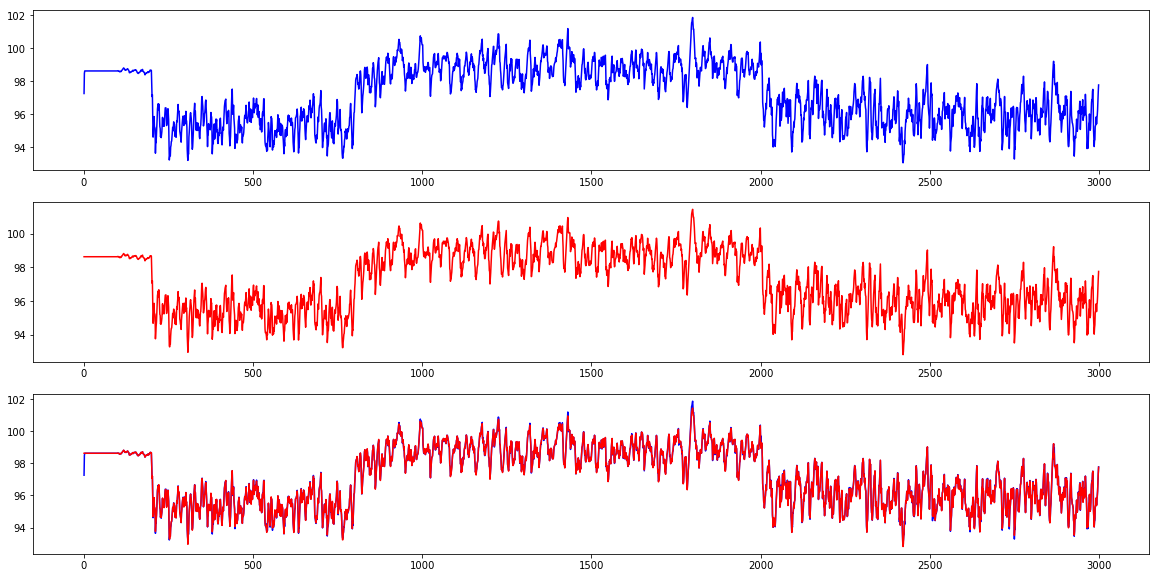

MSE on identification:  0.00305435104498


In [77]:
plt.subplot(311)
plt.plot(y_hat, color='blue')
plt.subplot(312)
plt.plot(y_id, color='red')
plt.subplot(313)
plt.plot(y_hat, color='blue')
plt.plot(y_id, color='red')
plt.show()

MSE_id = mean_squared_error(y_id,y_hat)
print("MSE on identification: ", MSE_id)

In [78]:
#Validation
poly = PolynomialFeatures(poly_degree)

Y_val = np.array(y_val)
reg_u = np.full(X_deg,avg_u_val)
reg_y = np.full(AR_deg,avg_y_val)
PHI_val = []
for i in tqdm(range(VAL_LENGHT)):  
    if i!=0:
        reg_y = np.append(reg_y, Y_val[i])[1:]
        reg_u = np.append(reg_u, u_val[i])[1:]
    regressors = np.append(reg_u, reg_y)
    PHI_val.append(poly.fit_transform([regressors])[0])
PHI_val = np.array(PHI_val)
regressor_terms = poly.get_feature_names(features)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 919.95it/s]


In [79]:
PHI_final_val = np.zeros((PHI_val.shape[0], len(regressor_selected)))
for i in range(len(regressor_selected)):
    PHI_final_val[:,i] = PHI_val[:, regressor_selected[i]]

In [80]:
y_hat_val = np.dot(PHI_final_val, theta)

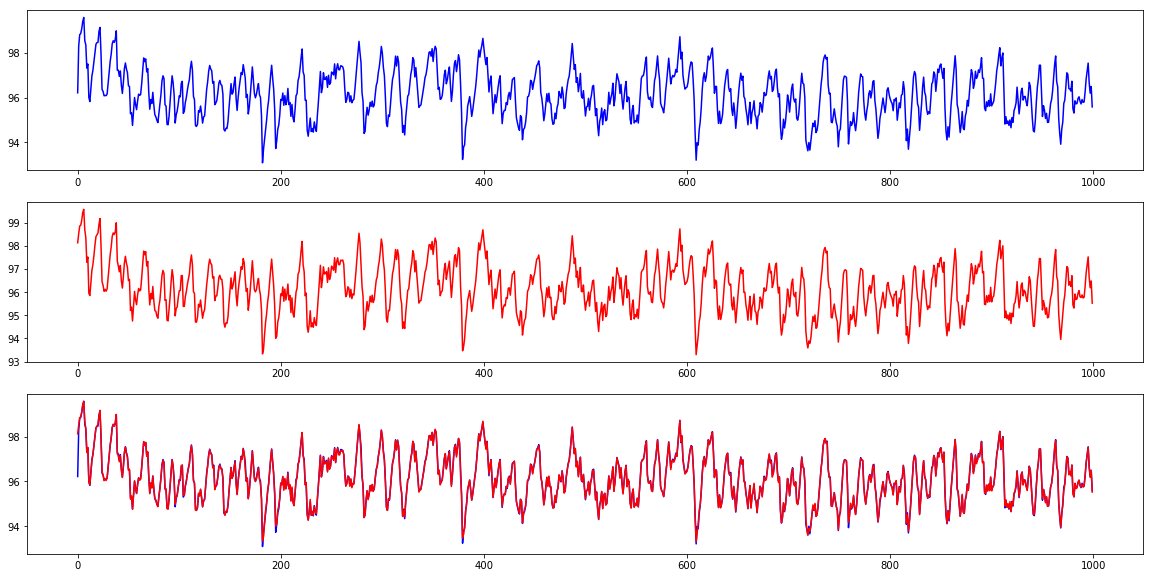

MSE on validation:  0.00641358305673


In [81]:
plt.subplot(311)
plt.plot(y_hat_val, color='blue')
plt.subplot(312)
plt.plot(y_val, color='red')
plt.subplot(313)
plt.plot(y_hat_val, color='blue')
plt.plot(y_val, color='red')
plt.show()

MSE_val = mean_squared_error(y_val,y_hat_val)
print("MSE on validation: ", MSE_val)

(-1, 1)

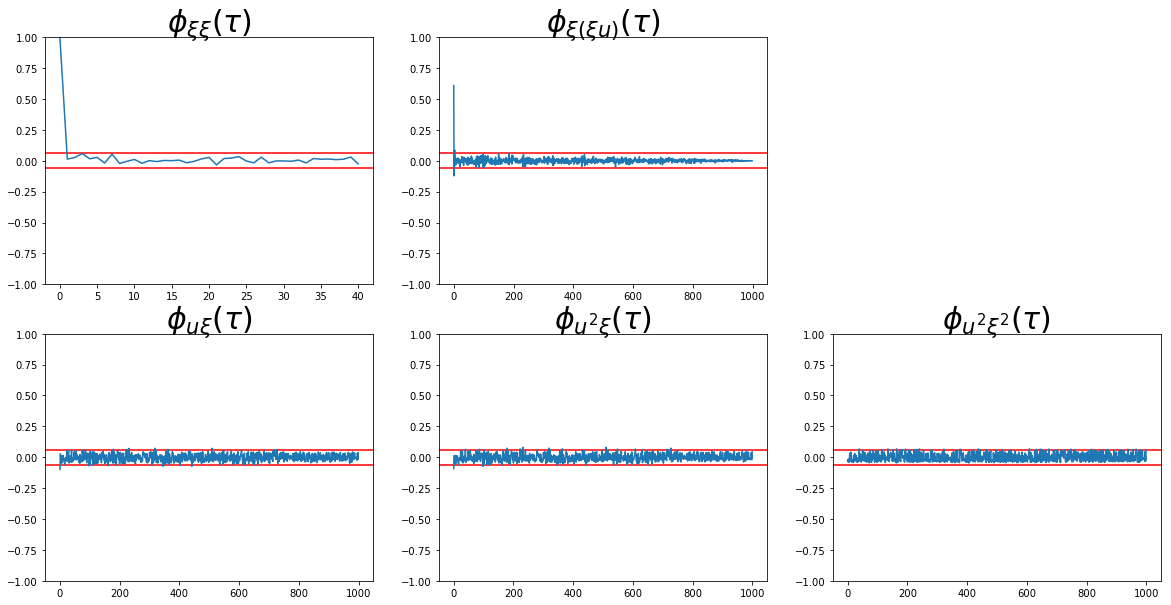

In [82]:
#MODEL VALIDATION - CORRELATION FUNCTIONS
from statsmodels.tsa.stattools import acf , ccf
epsilon = np.array(y_val - y_hat_val)
u_val = np.array(u_val)

#Autocorrelation epsilon
corr_ee = acf(epsilon)

#Cross-correlation u-epsilon
corr_ue = ccf(u_val, epsilon,unbiased=False)

#Cross-correlation epsilon ( epsilon*u)
corr_e_eu = ccf(epsilon,np.multiply(epsilon[1:],u_val[1:]),unbiased=False)

#Cross-correlation delta(u^2)-epsilon
corr_du2_e = ccf(np.power(u_val,2) - np.mean(np.power(u_val,2)),epsilon, unbiased=False)

#Cross-correlation delta(u^2)-epsilon
corr_du2_e2 = ccf(np.power(u_val,2) - np.mean(np.power(u_val,2)),np.power(epsilon,2), unbiased=False)

#confidence interval   -95%
conf_interval_sup = 1.96 / np.sqrt(VAL_LENGHT)
conf_interval_inf = -1.96 / np.sqrt(VAL_LENGHT)
plt.subplot(231)
plt.title(r'$\phi_{\xi\xi}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_ee)
plt.ylim((-1,1))
plt.subplot(232)
plt.title(r'$\phi_{\xi(\xi u)}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_e_eu)
plt.ylim((-1,1))
plt.subplot(234)
plt.title(r'$\phi_{u \xi}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_ue)
plt.ylim((-1,1))
plt.subplot(235)
plt.title(r'$\phi_{u^2\xi}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_du2_e)
plt.ylim((-1,1))
plt.subplot(236)
plt.title(r'$\phi_{u^2\xi^2}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_du2_e2)
plt.ylim((-1,1))


In [83]:
## Simulation 
# start from initial phi, then build step by step each ne element
poly = PolynomialFeatures(poly_degree)
reg_y = np.full(AR_deg,avg_y_val)
reg_u = np.full(X_deg,avg_u_val)
reg = np.append(reg_u,reg_y)
reg = poly.fit_transform([reg])[0]

In [84]:
model_reg = reg[regressor_selected]  # initial values for the regression

In [85]:
#simulate the process
y_hat_sim  = []
for i in range(VAL_LENGHT):
    y_i = np.dot(model_reg,theta) #simulated
    y_hat_sim.append(y_i)
    reg_y = np.append(reg_y, y_hat_sim[i])[1:]
    reg_u = np.append(reg_u, u_val[i])[1:]  #append at beggining, then remove last one( [:-1])
    reg = np.append(reg_u,reg_y)
    reg = poly.fit_transform([reg])[0]
    model_reg = reg[regressor_selected]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

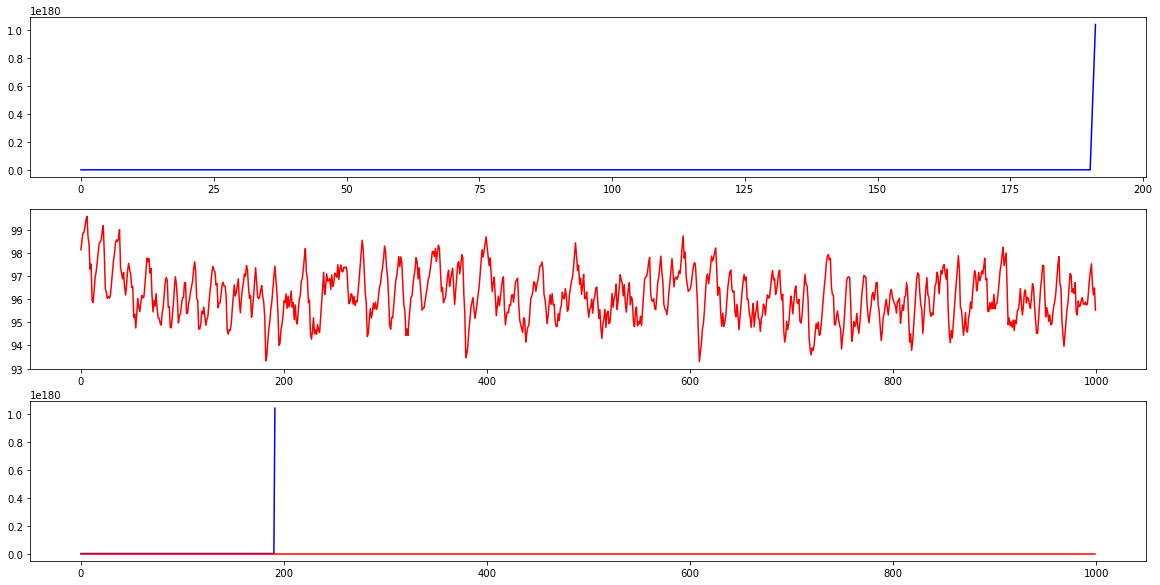

ValueError: Found input variables with inconsistent numbers of samples: [1000, 193]

In [86]:
plt.subplot(311)
plt.plot(y_hat_sim, color='blue')
plt.subplot(312)
plt.plot(y_val, color='red')
plt.subplot(313)
plt.plot(y_hat_sim, color='blue')
plt.plot(y_val, color='red')
plt.show()

MSE_sim = mean_squared_error(y_val,y_hat_sim)
print("MSE on simulation: ", MSE_sim)